In [1]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
pd.set_option('display.max_columns', 500)
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

## For visualisation 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

## For model building
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from imblearn.under_sampling import NearMiss

## For counting the balanced and inbalanced dataset
from collections import Counter

# Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read the dataset

In [109]:
df = pd.read_csv(r'https://raw.githubusercontent.com/Sahiljosan/Python_Projects/main/Dataset_Datathon_Fraud_Detection_28122022.csv')
df.head()

,customer_id,event_dttm_Deli,event_type_nm,client_defined_event_type_nm,event_desc,operaton_amt_100 (rupees),active phone call,remote desktop protokol,emulator,f,device_id,os,device_model,screensize,agentconnectiontype,screen_hash,device for user,reciever,password change,fast change of ip,ip not equal to previous
0,customer_id_0,2022-10-01 10:51:36,CHANGE_PASSWORD,RENEW,Login password recovery,0.0,NaN,NaN,NaN,St Petersburg,NaN,NaN,NaN,NaN,NaN,287067538.0,new,old,NaN,NaN,IP differes
1,customer_id_0,2022-10-01 11:15:21,SESSION_SIGNIN,SESSION_SIGNIN,Login,0.0,NaN,NaN,NaN,St Petersburg,NaN,NaN,NaN,NaN,NaN,287067538.0,new,old,happened on the same day,NaN,IP differes
2,customer_id_0,2022-10-01 11:31:55,SESSION_SIGNIN,SESSION_SIGNIN,Login,0.0,NaN,NaN,NaN,St Petersburg,NaN,NaN,NaN,NaN,NaN,-205759950.0,new,old,happened on the same day,NaN,IP differes
3,customer_id_0,2022-10-01 11:45:42,SESSION_SIGNIN,SESSION_SIGNIN,Login,0.0,NaN,NaN,NaN,St Petersburg,NaN,NaN,NaN,NaN,NaN,287067538.0,new,old,happened on the same day,NaN,IP differes
4,customer_id_0,2022-10-03 10:28:24,DEPOSIT,100_BKO,Payment order,116820.0,1.0,False,NaN,NaN,device_id_1,iOS,iPhone,375x812,wifi,NaN,NaN,old,NaN,NaN,NaN


# Segregate the features

In [4]:
numeric = [
    'operaton_amt_100 (rupees)'
]

categoric = [
    'event_type_nm'
    ,'client_defined_event_type_nm'
    ,'active phone call'
    ,'remote desktop protokol'
    ,'device for user'
    ,'reciever'
    ,'password change'
    ,'fast change of ip'
]
ts_columns = [
    'event_dttm_Deli'
]

In [5]:
numeric_pipeline = Pipeline(steps=[
            ('impute', SimpleImputer(strategy='mean')),
            ('scale', StandardScaler())
            ])
        
ohe_pipeline = Pipeline(steps=[
    # ('impute', SimpleImputer(strategy="constant", fill_value="NA")),
    ('ohe', OneHotEncoder(sparse_output=False, drop='first'))
    ])

## Associate the pipelines with the column names
Now once the pipeline steps are created associate with the particular column names on which to apply the transformations

In [6]:
transformers = [
            ('number', numeric_pipeline, numeric),
            ('ohe', ohe_pipeline, categoric)
]

## Perform the full processing
The argument verbose_feature_names_out = True makes sure the transformation names are added as 'number__', 'ohe__', 'oe__' and so on.

In [7]:
full_processor = ColumnTransformer(transformers=transformers, verbose_feature_names_out=True)
transformed_dataset = pd.DataFrame(full_processor.fit_transform(df),
                                   columns=full_processor.get_feature_names_out()
                                   )
transformed_dataset.head()

,number__operaton_amt_100 (rupees),ohe__event_type_nm_CARD_PIN_CHANGE,ohe__event_type_nm_CHANGE_ALERT_SETTINGS,ohe__event_type_nm_CHANGE_PASSWORD,ohe__event_type_nm_CHECK,ohe__event_type_nm_CLIENT_DEFINED,ohe__event_type_nm_DEPOSIT,ohe__event_type_nm_PAYMENT,ohe__event_type_nm_REQUEST_CREDIT,ohe__event_type_nm_REQUEST_NEW_CARD,ohe__event_type_nm_SESSION_SIGNIN,ohe__event_type_nm_UPDATE_USER,ohe__event_type_nm_USER_DETAILS,ohe__event_type_nm_VIEW_STATEMENT,ohe__event_type_nm_WITHDRAW,ohe__client_defined_event_type_nm_100_BKO_DEPOSIT,ohe__client_defined_event_type_nm_ACCEPT_AUTOPAYMENT_M2M,ohe__client_defined_event_type_nm_ACCEPT_AUTOPAYMENT_M2M_MOB_APP,ohe__client_defined_event_type_nm_ACCOUNT_FUNDING,ohe__client_defined_event_type_nm_APPROVED_CREDIT,ohe__client_defined_event_type_nm_ATM,ohe__client_defined_event_type_nm_ATM_BALANCE,ohe__client_defined_event_type_nm_ATM_DEPOSIT,ohe__client_defined_event_type_nm_ATM_MINI_ST,ohe__client_defined_event_type_nm_ATM_P2P_CREDIT,ohe__client_defined_event_type_nm_ATM_P2P_DEBIT,ohe__client_defined_event_type_nm_ATM_P2P_TRANSFER,ohe__client_defined_event_type_nm_ATM_PIN,ohe__client_defined_event_type_nm_ATM_PIN_CHECK,ohe__client_defined_event_type_nm_ATM_ST,ohe__client_defined_event_type_nm_ATM_WITHDRAW,ohe__client_defined_event_type_nm_C2BPAY,ohe__client_defined_event_type_nm_C2BPAY_MOB_APP,ohe__client_defined_event_type_nm_C2C,ohe__client_defined_event_type_nm_C2C_REQUEST,ohe__client_defined_event_type_nm_C2C_REQUEST_MOB_APP,ohe__client_defined_event_type_nm_C2C_RESPONSE,ohe__client_defined_event_type_nm_C2C_RESPONSE_CLIENT_DEFINED,ohe__client_defined_event_type_nm_C2C_RESPONSE_MOB_APP,ohe__client_defined_event_type_nm_CARDHOLDER_PAYMENT,ohe__client_defined_event_type_nm_CARDHOLDER_PAYMENT_DEPOSIT,ohe__client_defined_event_type_nm_CASH,ohe__client_defined_event_type_nm_CHANGE,ohe__client_defined_event_type_nm_CLOSE_ACCOUNT,ohe__client_defined_event_type_nm_CREDIT,ohe__client_defined_event_type_nm_CREDIT_PAYOUT,ohe__client_defined_event_type_nm_CREDIT_PAYOUT_MOB_APP,ohe__client_defined_event_type_nm_Construction,ohe__client_defined_event_type_nm_DEPOSITS_MOB_APP_PAYMENT,ohe__client_defined_event_type_nm_DEPOSITS_PAYMENT,ohe__client_defined_event_type_nm_Deposits,ohe__client_defined_event_type_nm_ED101_INC,ohe__client_defined_event_type_nm_EXTERNAL_TRANSFER,ohe__client_defined_event_type_nm_EXTERNAL_TRANSFER_MOB_APP_PAYMENT,ohe__client_defined_event_type_nm_EXTERNAL_TRANSFER_PAYMENT,ohe__client_defined_event_type_nm_ExternalTransferGeneral,ohe__client_defined_event_type_nm_GET_CVV,ohe__client_defined_event_type_nm_GET_CVV_MOB_APP,ohe__client_defined_event_type_nm_HomeInternet,ohe__client_defined_event_type_nm_INCREASE_CREDIT_LIMIT_MOB_APP,ohe__client_defined_event_type_nm_INCREASE_DAY_LIMIT,ohe__client_defined_event_type_nm_INCREASE_DAY_LIMIT_MOB_APP,ohe__client_defined_event_type_nm_INCREASE_MONTH_LIMIT,ohe__client_defined_event_type_nm_INTERNATIONAL_TRANSFER_PAYMENT,ohe__client_defined_event_type_nm_InternetBankingGeneral,ohe__client_defined_event_type_nm_LOAN_CONSENT,ohe__client_defined_event_type_nm_LOAN_CONSENT_MOB_APP,ohe__client_defined_event_type_nm_MOB_APP_CHANGE_PASSWORD,ohe__client_defined_event_type_nm_MOB_APP_SESSION_SIGNIN,ohe__client_defined_event_type_nm_MobileCommunication,ohe__client_defined_event_type_nm_ONLINE_PRODUCT_DBO_RC,ohe__client_defined_event_type_nm_ONLINE_PRODUCT_DBO_RC_MOB_APP,ohe__client_defined_event_type_nm_OTHER_PAYMENT,ohe__client_defined_event_type_nm_POS,ohe__client_defined_event_type_nm_POS_CARD_VERIFICATION,ohe__client_defined_event_type_nm_POS_MAIL_PHONE_ORDER,ohe__client_defined_event_type_nm_POS_P2P_CREDIT,ohe__client_defined_event_type_nm_POS_P2P_DEBIT,ohe__client_defined_event_type_nm_POS_P2P_TRANSFER,ohe__client_defined_event_type_nm_POS_PRE_PURCHASE,ohe__client_defined_event_type_nm_POS_PRE_PURCHASE_CL,ohe__client_defined_event_type_nm_POS_PURCHASE,ohe__client_defined_event_type_nm_POS_QUASI_CASH,ohe__client_defined_event_type_nm_POS_RETURN,o

In [22]:
len(transformed_dataset.columns)

124

In [8]:
transformed_dataset.columns[110:]

Index(['ohe__client_defined_event_type_nm_VIRTUAL_CREDIT_CARD_MOB_APP',
       'ohe__client_defined_event_type_nm_WITHDRAWAL_ACCOUNT',
       'ohe__client_defined_event_type_nm_WITHDRAWAL_ACCOUNT_MOB_APP',
       'ohe__client_defined_event_type_nm_WithoutRisk',
       'ohe__client_defined_event_type_nm_nan', 'ohe__active phone call_1.0',
       'ohe__active phone call_nan', 'ohe__remote desktop protokol_True',
       'ohe__remote desktop protokol_nan', 'ohe__device for user_old',
       'ohe__device for user_nan', 'ohe__reciever_old',
       'ohe__password change_nan', 'ohe__fast change of ip_nan'],
      dtype='object')

In [21]:
df.columns

Index(['customer_id', 'event_dttm_Deli', 'event_type_nm',
       'client_defined_event_type_nm', 'event_desc',
       'operaton_amt_100 (rupees)', 'active phone call',
       'remote desktop protokol', 'emulator', 'f', 'device_id', 'os',
       'device_model', 'screensize', 'agentconnectiontype', 'screen_hash',
       'device for user', 'reciever', 'password change', 'fast change of ip',
       'ip not equal to previous'],
      dtype='object')

# Perform cosine similarity
Perform the cosine similarity such with the flagged transaction

In [10]:
df.emulator.isna().sum()

8046

## First label the transactions which are probably fraud
Transactions having high similarity and unlabelled with fraud records are marked as 322

In [11]:
# get the flagged transaction
unlabelled_mask = df.emulator.isna()
positive_mask = df.emulator == 322
# labelled_dataset = transformed_dataset.loc[~unlabelled_mask,:]
unlabelled_dataset = transformed_dataset.loc[unlabelled_mask,:]
positive_dataset = transformed_dataset.loc[positive_mask,:]
cosine_map = cosine_similarity(unlabelled_dataset, positive_dataset)
cosine_map_df = pd.DataFrame(cosine_map, index=unlabelled_dataset.index, columns=positive_dataset.index)

In [12]:
cosine_map_df

,3029,3030
0,0.619041,0.341513
1,0.336786,0.550274
2,0.336786,0.550274
3,0.336786,0.550274
4,0.644644,0.346553
...,...,...
10964,0.502589,0.913344
10965,0.502589,0.913344
10966,0.502521,0.550199
10967,0.502589,0.913344


# Mention the cosine similarity threshold
This threshold is to label the unlabelled records as possible fraud.

In [13]:
threshold = 0.85
cosine_bool = cosine_map >= threshold
# for each row if it matches any of the fraudulent record i.e threshold of
## similarity, mark it as fraudulent
cosine_crosses_threshold = np.logical_or(cosine_bool[:,0],cosine_bool[:,1])

In [14]:
# for the unlabelled data, get the rows for which cosine similarity crossed 0.85
df.loc[unlabelled_mask,:].loc[cosine_crosses_threshold,:].shape

(200, 21)

**Observations:** We could see that there are 200 transactions which:
1. Don't have emulator label provided.
2. Shows similar characteristics by a similarity of 0.85 as that of fraudulent ones by the features we selected.

Below are some samples

## Sample observations that matches fraud records

### The fraud records

In [15]:
df.loc[positive_mask,numeric+categoric]

,operaton_amt_100 (rupees),event_type_nm,client_defined_event_type_nm,active phone call,remote desktop protokol,device for user,reciever,password change,fast change of ip
3029,0.0,CHANGE_PASSWORD,MOB_APP_CHANGE_PASSWORD,0.0,False,NaN,old,NaN,NaN
3030,0.0,SESSION_SIGNIN,MOB_APP_SESSION_SIGNIN,0.0,False,old,old,happened on the same day,NaN


### The sample

In [16]:
sample = df.loc[unlabelled_mask,:].loc[cosine_crosses_threshold,numeric+categoric].sample()
sample

,operaton_amt_100 (rupees),event_type_nm,client_defined_event_type_nm,active phone call,remote desktop protokol,device for user,reciever,password change,fast change of ip
202,0.0,SESSION_SIGNIN,MOB_APP_SESSION_SIGNIN,0.0,False,old,old,NaN,NaN


### The cosine similarity computed for the same record

In [17]:
cosine_map_df.loc[sample.index,:]

,3029,3030
202,0.502589,0.913344


# Mark the above records as fraudulent and rest as non-fraudulent

In [18]:
fraud_marked = df.loc[unlabelled_mask,:].loc[cosine_crosses_threshold,:]
fraud_marked.emulator = 322 # mark them as fraud
# pop out the indices from actual df to remove the above rows
df.drop(index=fraud_marked.index.tolist(), inplace=True)
# whichever row has is still unmarked emulator mark them as non-fraud
df.loc[df.emulator.isna(),'emulator'] = 0
# append the other dataframe to the original
df = pd.concat((df,fraud_marked), axis=0)

In [19]:
df.emulator.value_counts()

0.0      10767
322.0      202
Name: emulator, dtype: int64

# Seperate Independent and Dependent Features


In [24]:
X = transformed_dataset
y = df['emulator']

In [25]:
X.head()

,number__operaton_amt_100 (rupees),ohe__event_type_nm_CARD_PIN_CHANGE,ohe__event_type_nm_CHANGE_ALERT_SETTINGS,ohe__event_type_nm_CHANGE_PASSWORD,ohe__event_type_nm_CHECK,ohe__event_type_nm_CLIENT_DEFINED,ohe__event_type_nm_DEPOSIT,ohe__event_type_nm_PAYMENT,ohe__event_type_nm_REQUEST_CREDIT,ohe__event_type_nm_REQUEST_NEW_CARD,ohe__event_type_nm_SESSION_SIGNIN,ohe__event_type_nm_UPDATE_USER,ohe__event_type_nm_USER_DETAILS,ohe__event_type_nm_VIEW_STATEMENT,ohe__event_type_nm_WITHDRAW,ohe__client_defined_event_type_nm_100_BKO_DEPOSIT,ohe__client_defined_event_type_nm_ACCEPT_AUTOPAYMENT_M2M,ohe__client_defined_event_type_nm_ACCEPT_AUTOPAYMENT_M2M_MOB_APP,ohe__client_defined_event_type_nm_ACCOUNT_FUNDING,ohe__client_defined_event_type_nm_APPROVED_CREDIT,ohe__client_defined_event_type_nm_ATM,ohe__client_defined_event_type_nm_ATM_BALANCE,ohe__client_defined_event_type_nm_ATM_DEPOSIT,ohe__client_defined_event_type_nm_ATM_MINI_ST,ohe__client_defined_event_type_nm_ATM_P2P_CREDIT,ohe__client_defined_event_type_nm_ATM_P2P_DEBIT,ohe__client_defined_event_type_nm_ATM_P2P_TRANSFER,ohe__client_defined_event_type_nm_ATM_PIN,ohe__client_defined_event_type_nm_ATM_PIN_CHECK,ohe__client_defined_event_type_nm_ATM_ST,ohe__client_defined_event_type_nm_ATM_WITHDRAW,ohe__client_defined_event_type_nm_C2BPAY,ohe__client_defined_event_type_nm_C2BPAY_MOB_APP,ohe__client_defined_event_type_nm_C2C,ohe__client_defined_event_type_nm_C2C_REQUEST,ohe__client_defined_event_type_nm_C2C_REQUEST_MOB_APP,ohe__client_defined_event_type_nm_C2C_RESPONSE,ohe__client_defined_event_type_nm_C2C_RESPONSE_CLIENT_DEFINED,ohe__client_defined_event_type_nm_C2C_RESPONSE_MOB_APP,ohe__client_defined_event_type_nm_CARDHOLDER_PAYMENT,ohe__client_defined_event_type_nm_CARDHOLDER_PAYMENT_DEPOSIT,ohe__client_defined_event_type_nm_CASH,ohe__client_defined_event_type_nm_CHANGE,ohe__client_defined_event_type_nm_CLOSE_ACCOUNT,ohe__client_defined_event_type_nm_CREDIT,ohe__client_defined_event_type_nm_CREDIT_PAYOUT,ohe__client_defined_event_type_nm_CREDIT_PAYOUT_MOB_APP,ohe__client_defined_event_type_nm_Construction,ohe__client_defined_event_type_nm_DEPOSITS_MOB_APP_PAYMENT,ohe__client_defined_event_type_nm_DEPOSITS_PAYMENT,ohe__client_defined_event_type_nm_Deposits,ohe__client_defined_event_type_nm_ED101_INC,ohe__client_defined_event_type_nm_EXTERNAL_TRANSFER,ohe__client_defined_event_type_nm_EXTERNAL_TRANSFER_MOB_APP_PAYMENT,ohe__client_defined_event_type_nm_EXTERNAL_TRANSFER_PAYMENT,ohe__client_defined_event_type_nm_ExternalTransferGeneral,ohe__client_defined_event_type_nm_GET_CVV,ohe__client_defined_event_type_nm_GET_CVV_MOB_APP,ohe__client_defined_event_type_nm_HomeInternet,ohe__client_defined_event_type_nm_INCREASE_CREDIT_LIMIT_MOB_APP,ohe__client_defined_event_type_nm_INCREASE_DAY_LIMIT,ohe__client_defined_event_type_nm_INCREASE_DAY_LIMIT_MOB_APP,ohe__client_defined_event_type_nm_INCREASE_MONTH_LIMIT,ohe__client_defined_event_type_nm_INTERNATIONAL_TRANSFER_PAYMENT,ohe__client_defined_event_type_nm_InternetBankingGeneral,ohe__client_defined_event_type_nm_LOAN_CONSENT,ohe__client_defined_event_type_nm_LOAN_CONSENT_MOB_APP,ohe__client_defined_event_type_nm_MOB_APP_CHANGE_PASSWORD,ohe__client_defined_event_type_nm_MOB_APP_SESSION_SIGNIN,ohe__client_defined_event_type_nm_MobileCommunication,ohe__client_defined_event_type_nm_ONLINE_PRODUCT_DBO_RC,ohe__client_defined_event_type_nm_ONLINE_PRODUCT_DBO_RC_MOB_APP,ohe__client_defined_event_type_nm_OTHER_PAYMENT,ohe__client_defined_event_type_nm_POS,ohe__client_defined_event_type_nm_POS_CARD_VERIFICATION,ohe__client_defined_event_type_nm_POS_MAIL_PHONE_ORDER,ohe__client_defined_event_type_nm_POS_P2P_CREDIT,ohe__client_defined_event_type_nm_POS_P2P_DEBIT,ohe__client_defined_event_type_nm_POS_P2P_TRANSFER,ohe__client_defined_event_type_nm_POS_PRE_PURCHASE,ohe__client_defined_event_type_nm_POS_PRE_PURCHASE_CL,ohe__client_defined_event_type_nm_POS_PURCHASE,ohe__client_defined_event_type_nm_POS_QUASI_CASH,ohe__client_defined_event_type_nm_POS_RETURN,o

In [26]:
y = y.astype(int)

In [27]:
y = y.replace(322,1)

In [28]:
y.unique()

array([0, 1])

In [29]:
y.value_counts()

0    10767
1      202
Name: emulator, dtype: int64

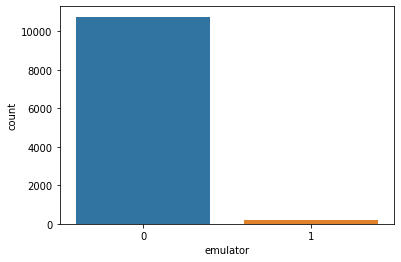

In [30]:
import seaborn as sns
sns.countplot(data = df,x = y)

**Observation:** From the countplot we can see, the data is very inbalance so we have to balance the data .. 

# Handle the inbalance data
using NearMiss()

In [31]:
nm = NearMiss()
x_imb,y_imb= nm.fit_resample(X,y)

In [32]:
print("Original dataset shape {}".format(Counter(y)))
print("Resampled dataset shape {}".format(Counter(y_imb)))

Original dataset shape Counter({0: 10767, 1: 202})
Resampled dataset shape Counter({0: 202, 1: 202})


# Split data into Training and Testing dataset

In [33]:
x_train,x_test,y_train,y_test = train_test_split(x_imb,y_imb,test_size=0.20,random_state=42)

In [34]:
x_train.shape,y_train.shape

((323, 124), (323,))

In [35]:
x_test.shape,y_test.shape

((81, 124), (81,))

In [36]:
y_train.value_counts()

1    167
0    156
Name: emulator, dtype: int64

In [37]:
y_test.value_counts()

0    46
1    35
Name: emulator, dtype: int64

# Standardize the data using StandardScaler

In [38]:
scaler = StandardScaler()
scaler

StandardScaler()

In [39]:
x_train = scaler.fit_transform(x_train)

In [40]:
x_test = scaler.transform(x_test)

In [41]:
pd.DataFrame(x_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123
0,0.668779,-0.096825,-0.242933,-0.055728,0.0,0.0,0.0,1.493318,0.0,0.0,-1.258571,0.0,0.0,-0.055728,-0.078934,0.0,0.0,0.0,0.0,0.0,-0.078934,-0.055728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.354169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.055728,0.0,0.0,0.0,0.0,-0.482519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.342997,0.0,-0.078934,-0.055728,-0.111979,-0.055728,0.0,0.0,0.0,0.0,-0.055728,-0.078934,0.0,0.0,-0.055728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.242933,-0.055728,4.242641,0.0,0.0,0.0,0.0,0.0,0.0,-0.096825,-0.858230,0.0,1.728483,0.0,1.728483,-0.972514,1.728483,0.348608,0.779080,0.055728
1,-0.262630,-0.096825,-0.242933,-0.055728,0.0,0.0,0.0,-0.669650,0.0,0.0,0.794552,0.0,0.0,-0.055728,-0.078934,0.0,0.0,0.0,0.0,0.0,-0.078934,-0.055728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.354169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.055728,0.0,0.0,0.0,0.0,-0.482519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.342997,0.0,-0.078934,-0.055728,-0.111979,-0.055728,0.0,0.0,0.0,0.0,-0.055728,-0.078934,0.0,0.0,-0.055728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.242933,-0.055728,-0.235702,0.0,0.0,0.0,0.0,0.0,0.0,-0.096825,1.165188,0.0,-0.578542,0.0,-0.578542,-0.972514,-0.578542,0.348608,-1.283566,0.055728
2,-0.262630,-0.096825,-0.242933,-0.055728,0.0,0.0,0.0,-0.669650,0.0,0.0,0.794552,0.0,0.0,-0.055728,-0.078934,0.0,0.0,0.0,0.0,0.0,-0.078934,-0.055728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.354169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.055728,0.0,0.0,0.0,0.0,-0.482519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.342997,0.0,-0.078934,-0.055728,-0.111979,-0.055728,0.0,0.0,0.0,0.0,-0.055728,-0.078934,0.0,0.0,-0.055728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.242933,-0.055728,-0.235702,0.0,0.0,0.0,0.0,0.0,0.0,-0.096825,1.165188,0.0,-0.578542,0.0,-0.578542,1.028263,-0.578542,0.348608,-1.283566,0.055728
3,-0.262630,-0.096825,-0.242933,-0.055728,0.0,0.0,0.0,-0.669650,0.0,0.0,0.794552,0.0,0.0,-0.055728,-0.078934,0.0,0.0,0.0,0.0,0.0,-0.078934,-0.055728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.354169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.055728,0.0,0.0,0.0,0.0,2.072458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.342997,0.0,-0.078934,-0.055728,-0.111979,-0.055728,0.0,0.0,0.0,0.0,-0.055728,-0.078934,0.0,0.0,-0.055728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.242933,-0.055728,-0.235702,0.0,0.0,0.0,0.0,0.0,0.0,-0.096825,-0.858230,0.0,-0.578542,0.0,-0.578542,1.028263,-0.578542,0.348608,0.779080,0.055728
4,-0.262630,-0.096825,-0.242933,-0.055728,0.0,0.0,0.0,-0.669650,0.0,0.0,0.794552,0.0,0.0,-0.055728,-0.078934,0.0,0.0,0.0,0.0,0.0,-0.078934,-0.055728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.354169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.055728,0.0,0.0,0.0,0.0,-0.482519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.342997,0.0,-0.078934,-0.055728,-0.111979,-0.055728,0.0,0.0,0.0,0.0,-0.055728,-0.078934,0.0,0.0,-0.055728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.242933,-0.055728,-0.235702,0.0,0.0,0.0,0.0,0.0,0.0,-0.096825,1.165188,0.0,-0.578542,0.0,-0.578542,1.028263,-0.578542,0.348608,0.779080,0.055728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

# Function for Model Training and Evaluation

In [42]:
# Create function that will evaluate the model
def model_evaluator(actual_val, pred_val):
    """
    This function takes actual value and predicted value as argument and returns Accuracy, Precision, Recall, F-1 Score.
    """
    acc= round(accuracy_score(actual_val,pred_val),5)
    prec = round(precision_score(actual_val,pred_val),5)
    rec = round(recall_score(actual_val,pred_val),5)
    roc_auc = round(roc_auc_score(actual_val,pred_val),5)
    return acc, prec, rec, roc_auc


# Create dictionary containing model objects for different algorithm
models = {
            "Logistic Regression" : LogisticRegression(),
            "Support Vector Classifier" : SVC(),
            "Decision Tree Classifier" : DecisionTreeClassifier(),
            "Random Forest classifier" : RandomForestClassifier(),
            "Bagging classifier" : BaggingClassifier(base_estimator= LogisticRegression()),
            "Extra Tree classifier" : ExtraTreesClassifier(),
            "AdaBoost Classifier" : AdaBoostClassifier(),
            "Gradient Boost Classifier" : GradientBoostingClassifier(),
            "XG Boost Classifier" : XGBClassifier()
}


## Create function for model training 
def model_trainer(model, x_train_data, y_train_data, x_test_data):
    model.fit(x_train_data,y_train_data)
    y_train_pred = model.predict(x_train_data)
    pred_val = model.predict(x_test_data)
    return y_train_pred, pred_val

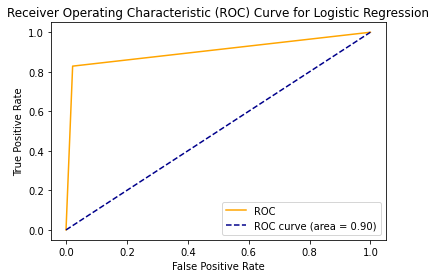

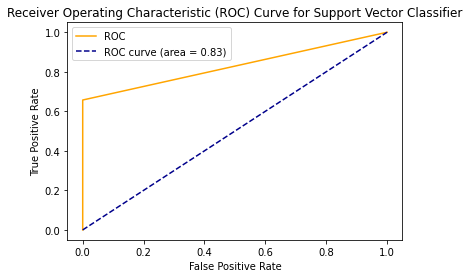

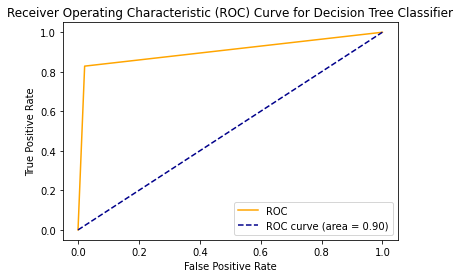

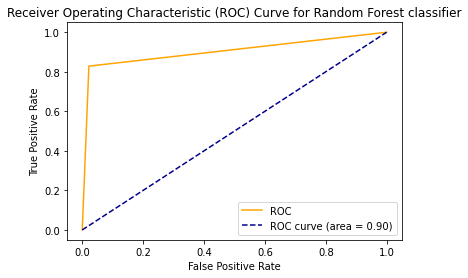

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


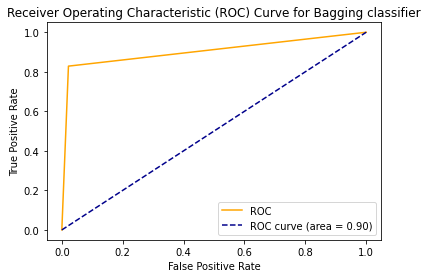

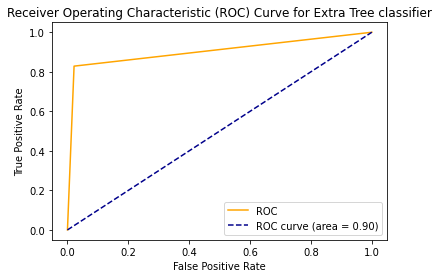

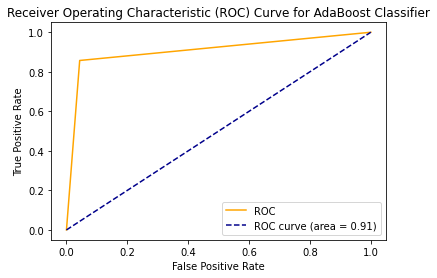

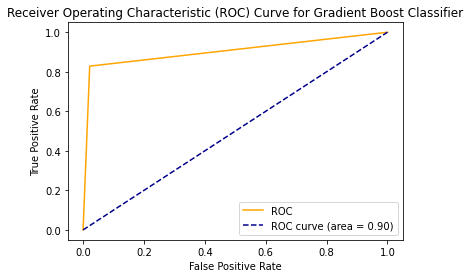

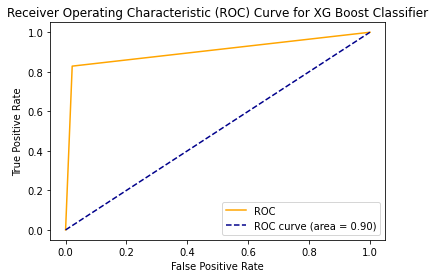

In [43]:
### Creating empty list to store model names
model_list=[]
### creating empty list to store accuracy score for each model
train_acc_score_list=[]
test_acc_score_list=[]
### creating empty list for storing precision score
train_prec_score_list=[]
test_prec_score_list=[]
### creating list to store recall score
train_recall_list=[]
test_recall_list=[]
### creating list to store roc_auc score
train_roc_auc_list=[]
test_roc_auc_list=[]


## Taining all models and getting their performance and storing in the empty list
for i in range(len(models.keys())):
    # model selection
    model = list(models.values())[i]

    ## getting train data and test data prediction
    y_train_pred, pred_val = model_trainer(model,x_train,y_train,x_test)

    ## getting model performance parameters for train data
    acc1, prec1, rec1, roc_auc1 = model_evaluator(y_train,y_train_pred)

    ## getting model performance parameters for test data
    acc, prec, rec, roc_auc = model_evaluator(y_test,pred_val)

    ## plot the ROC Curve (Receiver Operating Characteristic Curve)
    fpr, tpr, thresholds = roc_curve(y_test, pred_val)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for {}'.format(list(models.keys())[i]))
    plt.legend()
    plt.show()

    ## Append values to respective lists
    model_list.append(list(models.keys())[i])

    train_acc_score_list.append(acc1)
    test_acc_score_list.append(acc)

    train_prec_score_list.append(prec1)
    test_prec_score_list.append(prec)

    train_recall_list.append(rec1)
    test_recall_list.append(rec)
    
    train_roc_auc_list.append(roc_auc1)
    test_roc_auc_list.append(roc_auc)

In [44]:
all_models = pd.DataFrame(list(zip(model_list , train_acc_score_list , test_acc_score_list,
                                train_prec_score_list, test_prec_score_list,
                                train_recall_list, test_recall_list, train_roc_auc_list,test_roc_auc_list)),
            columns = ['Model','Train_Accuracy','Test_Accuracy',
                        'Train_Precision','Test_Precision',
                        'Train_Recall','Test_Recall',
                        'Train_Roc_Auc Score','Test_Roc_Auc Score']).sort_values(by ='Test_Accuracy',ascending= False).reset_index()
all_models.drop('index',axis = 1,inplace = True)
all_models

,Model,Train_Accuracy,Test_Accuracy,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Train_Roc_Auc Score,Test_Roc_Auc Score
0,Logistic Regression,0.90093,0.91358,0.94702,0.96667,0.85629,0.82857,0.90250,0.90342
1,Decision Tree Classifier,0.90093,0.91358,0.94702,0.96667,0.85629,0.82857,0.90250,0.90342
2,Random Forest classifier,0.90093,0.91358,0.94702,0.96667,0.85629,0.82857,0.90250,0.90342
3,Bagging classifier,0.90093,0.91358,0.94702,0.96667,0.85629,0.82857,0.90250,0.90342
4,Extra Tree classifier,0.90093,0.91358,0.94702,0.96667,0.85629,0.82857,0.90250,0.90342
5,AdaBoost Classifier,0.88545,0.91358,0.90625,0.93750,0.86826,0.85714,0.88605,0.90683
6,Gradient Boost Classifier,0.90093,0.91358,0.94702,0.96667,0.85629,0.82857,0.90250,0.90342
7,XG Boost Classifier,0.90093,0.91358,0.94702,0.96667,0.85629,0.82857,0.90250,0.90342
8,Support Vector Classifier,0.87307,0.85185,1.00000,1.00000,0.75449,0.65714,0.87725,0.82857


# **Hyperparameter tunning** on models showing higher accuracy

In [45]:
rfc_params={'n_estimators':[100,200, 300],
           'max_depth': [None, 5,10],
           'min_samples_leaf': [5,10,15]}

dtc_param = {'criterion' : ['gini','entropy'],
             'max_depth': [None, 5,10],
             'min_samples_leaf': [5,10,15]}


etc_params={'n_estimators':[100,200, 300],
           'max_depth': [None, 5,10],
           'min_samples_leaf': [5,10,15]}

gbc_params={'criterion': ['friedman_mse', 'squared_error', 'mse'],
            'n_estimators':[100,200, 300],
            'min_samples_split': [20,30,40]}

xgbc_params={'max_depth': [2,4,6],
            'min_child_weight': [2,4,6],
            'gamma': [i/10 for i in range(4)]}

In [46]:
## Create empty dictionary to store best parameters
model_param = {}

## Hyper-Parameter tunning for random forest Classifier

In [47]:
### HPT Random forest Classifier Model
model=RandomForestClassifier()
grid=GridSearchCV(estimator=model,param_grid=rfc_params, cv=2,  verbose=2,n_jobs=-1)
grid.fit(x_train, y_train)
model_param['Random forest Classifier']=grid.best_params_

Fitting 2 folds for each of 27 candidates, totalling 54 fits


## Hyper-Parameter tunning for Decision Tree Classifier

In [48]:
## HPT for Decision Tree Classifier
model = DecisionTreeClassifier() 
grid = GridSearchCV(estimator=model, param_grid = dtc_param, cv = 2, verbose= 2, n_jobs=-1)
grid.fit(x_train,y_train)
model_param['Decision Tree Classifier'] = grid.best_params_

Fitting 2 folds for each of 18 candidates, totalling 36 fits


## Hyper-Parameter tunning for Extra Tree classifier

In [49]:
## HPT on Extratrees Classifier 
model = ExtraTreesClassifier()
grid = GridSearchCV(estimator=model, param_grid= etc_params, cv= 2, verbose=2, n_jobs= -1)
grid.fit(x_train,y_train)
model_param['Extra Trees Classifier'] = grid.best_params_

Fitting 2 folds for each of 27 candidates, totalling 54 fits


## Hyper-Parameter tunning for Gradient Boost Classifier

In [50]:
## HPT on Gradiant Boost classifier
model = GradientBoostingClassifier()
grid = GridSearchCV(estimator=model , param_grid= gbc_params, cv = 2, verbose = 2, n_jobs = -1)
grid.fit(x_train,y_train)
model_param['Gradiant Boost classifier'] = grid.best_params_

Fitting 2 folds for each of 27 candidates, totalling 54 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/usr/local/lib/python3.8/dist-packages/sklearn/base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/utils/_param_v

## Hyper-Parameter tunning for XG Boost Classifier

In [51]:
### HPT XB Boost Classifier Model
model=XGBClassifier()
grid=GridSearchCV(estimator=model,param_grid=xgbc_params, cv=2,  verbose=2,n_jobs=-1)
grid.fit(x_train, y_train)
model_param['XBBoost Classifier']=grid.best_params_

Fitting 2 folds for each of 36 candidates, totalling 72 fits


In [52]:
model_param

{'Random forest Classifier': {'max_depth': 5,
  'min_samples_leaf': 15,
  'n_estimators': 100},
 'Decision Tree Classifier': {'criterion': 'gini',
  'max_depth': None,
  'min_samples_leaf': 10},
 'Extra Trees Classifier': {'max_depth': None,
  'min_samples_leaf': 15,
  'n_estimators': 100},
 'Gradiant Boost classifier': {'criterion': 'friedman_mse',
  'min_samples_split': 20,
  'n_estimators': 100},
 'XBBoost Classifier': {'gamma': 0.0, 'max_depth': 2, 'min_child_weight': 2}}

## Best Parameter for Hyper-Tuned models

In [53]:
for i in model_param:
    print("Best parameter for {} is {}".format(i,model_param[i]))

Best parameter for Random forest Classifier is {'max_depth': 5, 'min_samples_leaf': 15, 'n_estimators': 100}
Best parameter for Decision Tree Classifier is {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10}
Best parameter for Extra Trees Classifier is {'max_depth': None, 'min_samples_leaf': 15, 'n_estimators': 100}
Best parameter for Gradiant Boost classifier is {'criterion': 'friedman_mse', 'min_samples_split': 20, 'n_estimators': 100}
Best parameter for XBBoost Classifier is {'gamma': 0.0, 'max_depth': 2, 'min_child_weight': 2}


## Re-training Models with Best Hyper_parameters and Model evaluation

In [54]:
hyp_models = { "Random Forest Classifier" : RandomForestClassifier(max_depth = None, min_samples_leaf = 5, n_estimators = 200),
           "Decision Tree Classifier" : DecisionTreeClassifier(criterion = "gini", max_depth = 10, min_samples_leaf = 10),
           "Extra Trees Classifier" : ExtraTreesClassifier(max_depth= None, min_samples_leaf =  5, n_estimators = 300),
           "Gradiant Boost classifier" : GradientBoostingClassifier(criterion = 'friedman_mse', min_samples_split = 40, n_estimators = 300),
           "XGBoost Classifier" : XGBClassifier(gamma = 0.2, max_depth = 6, min_child_weight = 6 )           
}

In [55]:
### Creating empty list to store model names
model_list2=[]
### creating empty list to store accuracy score for each model
train_acc_score_list2=[]
test_acc_score_list2=[]
### creating empty list for storing precision score
train_prec_score_list2=[]
test_prec_score_list2=[]
### creating list to store recall score
train_recall_list2=[]
test_recall_list2=[]
### creating list to store roc_auc score
train_roc_auc_list2=[]
test_roc_auc_list2=[]


## Taining all models and getting their performance and storing in the empty list
for i in range(len(hyp_models.keys())):
    # model selection
    hyp_model = list(hyp_models.values())[i]

    ## getting train data and test data prediction
    y_train_pred, pred_val = model_trainer(hyp_model,x_train,y_train,x_test)

    ## getting model performance parameters for train data
    acc1, prec1, rec1, roc_auc1 = model_evaluator(y_train,y_train_pred)

    ## getting model performance parameters for test data
    acc, prec, rec, roc_auc = model_evaluator(y_test,pred_val)

    ## Append values to respective lists
    model_list2.append(list(models.keys())[i])

    train_acc_score_list2.append(acc1)
    test_acc_score_list2.append(acc)

    train_prec_score_list2.append(prec1)
    test_prec_score_list2.append(prec)

    train_recall_list2.append(rec1)
    test_recall_list2.append(rec)
    
    train_roc_auc_list2.append(roc_auc1)
    test_roc_auc_list2.append(roc_auc)

In [56]:
all_models_hyp = pd.DataFrame(list(zip(model_list2 , train_acc_score_list2 , test_acc_score_list2,
                                train_prec_score_list2, test_prec_score_list2,
                                train_recall_list2, test_recall_list2, train_roc_auc_list2,test_roc_auc_list2)),
            columns = ['Model','Train_Accuracy','Test_Accuracy',
                        'Train_Precision','Test_Precision',
                        'Train_Recall','Test_Recall',
                        'Train_Roc_Auc Score','Test_Roc_Auc Score']).sort_values(by ='Test_Accuracy',ascending= False).reset_index()
all_models_hyp.drop('index',axis = 1,inplace = True)
all_models_hyp

,Model,Train_Accuracy,Test_Accuracy,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Train_Roc_Auc Score,Test_Roc_Auc Score
0,Support Vector Classifier,0.88235,0.91358,0.90566,0.93750,0.86228,0.85714,0.88306,0.90683
1,Random Forest classifier,0.90093,0.91358,0.94702,0.96667,0.85629,0.82857,0.90250,0.90342
2,Bagging classifier,0.88545,0.91358,0.90625,0.93750,0.86826,0.85714,0.88605,0.90683
3,Logistic Regression,0.86378,0.85185,1.00000,1.00000,0.73653,0.65714,0.86826,0.82857
4,Decision Tree Classifier,0.86378,0.85185,1.00000,1.00000,0.73653,0.65714,0.86826,0.82857


- **Observation** 
- As we can see that after hyperparameter tunning Random Forest Classifier gives us the highest accuracy of 87% 
- Also the difference between train accuracy and test accuracy is very minimal so the model will not be overfitted.

In [ ]:
## Models showing accuracy without hyperparameter tunning
all_models

,Model,Train_Accuracy,Test_Accuracy,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Train_Roc_Auc Score,Test_Roc_Auc Score
0,Logistic Regression,0.91481,0.88060,0.96032,0.92727,0.87050,0.80952,0.91617,0.87659
1,Random Forest classifier,0.91481,0.88060,0.96032,0.92727,0.87050,0.80952,0.91617,0.87659
2,Bagging classifier,0.91481,0.88060,0.96032,0.92727,0.87050,0.80952,0.91617,0.87659
3,Extra Tree classifier,0.91481,0.88060,0.96032,0.92727,0.87050,0.80952,0.91617,0.87659
4,Decision Tree Classifier,0.91481,0.87313,0.96032,0.92593,0.87050,0.79365,0.91617,0.86866
5,Gradient Boost Classifier,0.91481,0.87313,0.96032,0.92593,0.87050,0.79365,0.91617,0.86866
6,XG Boost Classifier,0.91481,0.87313,0.96032,0.92593,0.87050,0.79365,0.91617,0.86866
7,AdaBoost Classifier,0.90000,0.86567,0.92424,0.88136,0.87770,0.82540,0.90068,0.86340
8,Support Vector Classifier,0.87778,0.84328,1.00000,1.00000,0.76259,0.66667,0.88129,0.83333
